In [48]:
!pip install datasets==2.13.1

In [49]:
from datasets import load_dataset
dataset=load_dataset('ms_marco','v1.1')

  0%|          | 0/3 [00:00<?, ?it/s]

In [50]:
subset=dataset['test']
subset[:2]

{'answers': [['Yes'],
  ['Fossil fuels are basically the remains of animals and plants and these are good energy resources. The three main fossil fuels are natural gas, oil, and coal. Fossil fuels are low in cost and are very important resources for our economy. Fossil fuels are used to generate electricity used as fuels for transportation.']],
 'passages': [{'is_selected': [0, 0, 1, 0, 0, 0, 0],
   'passage_text': ['We have been feeding our back yard squirrels for the fall and winter and we noticed that a few of them have missing fur. One has a patch missing down his back and under both arms. Also another has some missing on his whole chest. They are all eating and seem to have a good appetite.',
    'Critters cannot stand the smell of human hair, so sprinkling a barrier of hair clippings around your garden, or lightly working it into the soil when you plant bulbs, apparently does have some merit. The whole thing kind of makes me laugh. It never occurred to me that we are the ones tha

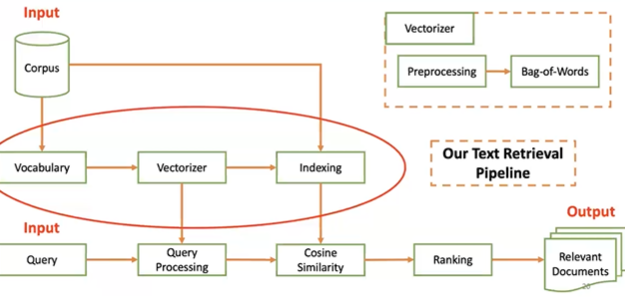

# **CREATE CORPUS**

In [51]:
#define list of document text
corpus=[]

for sample in subset:
    query_type=sample['query_type']
    if query_type!='entity':
        continue
    query_id=sample['query_id']
    query_str=sample['query']
    passage_dict=sample['passages']
    is_selected_lst=passage_dict['is_selected']
    passage_text_lst=passage_dict['passage_text']

    corpus+=passage_text_lst

In [52]:
corpus[:5]

['SUBPHYLUM CHELICERATA, CLASS ARACHNIDA. Spiders. This group contains many familiar organisms, including the spiders, mites, scorpions and ticks. Examine the large spider on the right. Again, notice that there are two body regions, a cephalothorax and an abdomen. On the cephalothorax are two to four pairs of simple eyes.',
 'The class Arachnida includes a diverse group of arthropods: spiders, scorpions, ticks, mites, harvestmen, and their cousins. Scientists describe over 75,000 species of arachnids, the majority of them spiders. Most arachnids are carnivorous, typically preying on insects, and terrestrial, living on land.',
 'Spiders belong to the phylum Arthropoda, along with insects and crustaceans. The order of spiders, Araneae—together with scorpions, harvestmen, and the large order of mites and ticks—make up the class of Arachnida. Spiders differ from other arachnids in having the body divided into cephalothorax and abdomen.',
 'The class Araneae contains the spiders, a large an

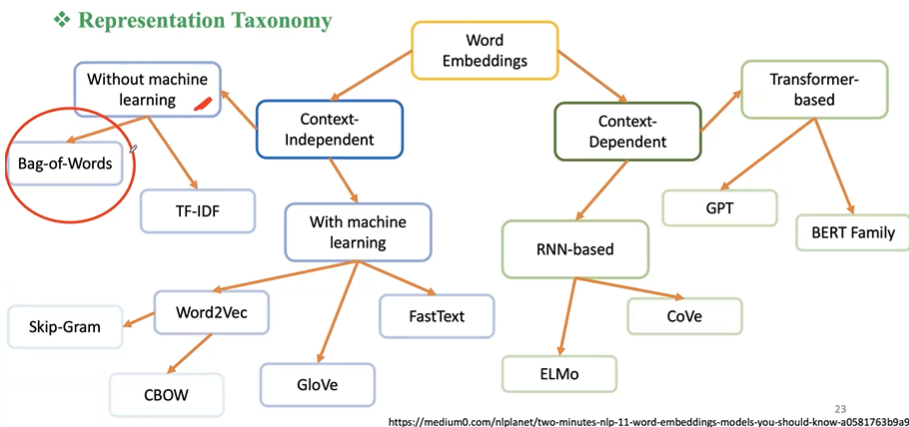

# **TEXT NORMALIZATION**

In [53]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')
#lower case
def lowercase(text):
    return text.lower()

#remove punctuation .,/;'{}[]-= etc.
remove_char=string.punctuation
def remove_punctuation(text):
    for char in remove_char:
        text=text.replace(char,'')
    return text

#remove stop word
stopword_lst=stopwords.words('english')
def remove_stopwords(text):
    tokens=tokenize(text)
    non_stopwords_lst=[
        token for token in tokens if token not in stopword_lst
    ]
    new_text=' '.join(non_stopwords_lst)
    return new_text

#stemming (likes -> like, horses -> horse, ate -> eat etc.)
stemmer=PorterStemmer()
def stemming(text):
    tokens=tokenize(text)
    stemmed_lst=[
        stemmer.stem(token) for token in tokens
    ]
    new_text=' '.join(stemmed_lst)
    return new_text

#text normalize
def text_normalize(text):
    text=lowercase(text)
    text=remove_punctuation(text)
    text=remove_stopwords(text)
    text=stemming(text)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **TEXT VECTORIZATION (BOW)**

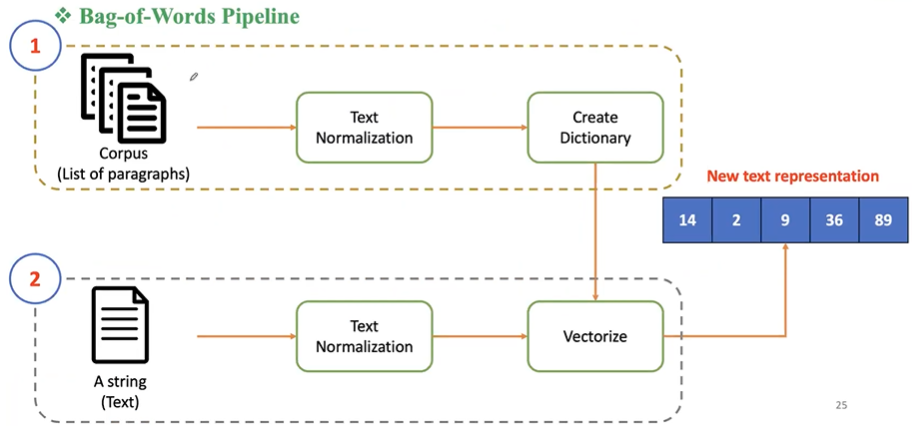

In [54]:
#Bag of word
def tokenize(text):
    return text.split()

def create_dictonary(corpus): #get unique words
    dictionary=[]
    for doc in corpus:
        normalized_doc=text_normalize(doc)
        tokens=tokenize(normalized_doc)
        for token in tokens:
            if token not in dictionary:
                dictionary.append(token)
    return dictionary

In [55]:
#Weighting: Term-frequency (Apply occurence to word)
def vectorize(text,dictionary):
    word_count_dict={word:0 for word in dictionary}
    normalized_text=text_normalize(text)
    tokens=tokenize(normalized_text)
    for token in tokens:
        try:
            word_count_dict[token]+=1
        except:
            pass
    vector=list(word_count_dict.values())
    return vector

# **INDEXING (Document-term matrix)**

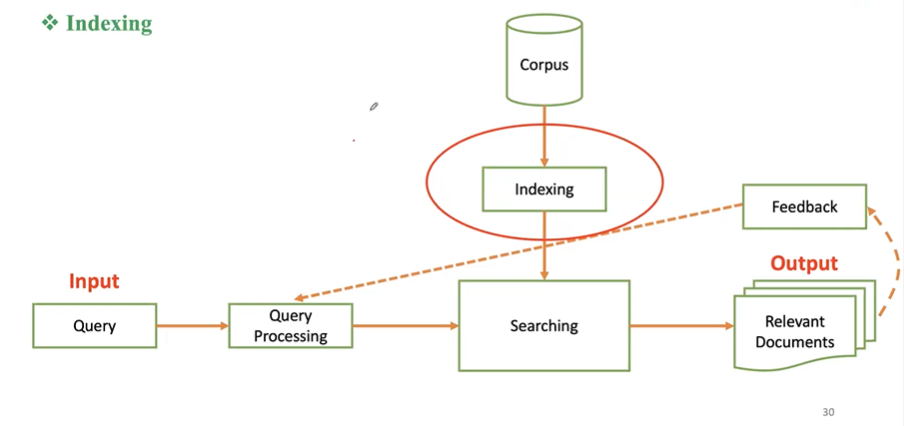

In [56]:
#Improve retrival speed
def create_doc_term_matrix(corpus,dictionary):
    doc_term_matrix={}
    for idx,doc in enumerate(corpus):
        vector=vectorize(doc,dictionary)
        doc_term_matrix[(doc,idx)]=vector
    return doc_term_matrix

# **RANKING**

In [57]:
from scipy import spatial

def similarity(a,b):
    return 1-spatial.distance.cosine(a,b)

In [58]:
def ranking(query,dictionary,doc_term_matrix):
    query_vec=vectorize(query,dictionary)
    scores=[]
    for doc_info,doc_vec in doc_term_matrix.items():
        sim=similarity(query_vec,doc_vec)
        scores.append((sim,doc_info))
    scores.sort(reverse=True)
    return scores

In [60]:
query_lst=['input something']
top_k=10
dictionary=create_dictonary(corpus)
doc_term_matrix=create_doc_term_matrix(corpus,dictionary)
for query in query_lst:
    scores=ranking(query,dictionary,doc_term_matrix)
    print(f'Query: {query}')
    print('=== Relevant Docs ===')
    for idx in range(top_k):
        doc_score=scores[idx][0]
        doc_content=scores[idx][1][0]

        print(f'Top {idx+1}, Score:{doc_score:.4f}')
        print(doc_content)
        print('\n')

Query: input something
=== Relevant Docs ===
Top 1, Score:0.2626
Chicken fried steak is a dish that's about taking something that's less than palatable, in this case a tough piece of beef, and with a little ingenuity turning it into something delectable, says Lisa Fain, the author of the Homesick Texan.


Top 2, Score:0.1925
Figurative Language Examples. The definition of figurative language is when you describe something by comparing it with something else. There are few different ways to use figurative language. See below for more information and examples of figurative language and how to use it. Remove these ads.


Top 3, Score:0.1796
noun. noun \ˈnau̇n\. : a word or phrase that is the name of something (as a person, place, or thing) and that is used in a sentence especially as subject or object of a verb or as object of a preposition. Spanish Central: Spanish translation of noun. : a word that is the name of something (such as a person, animal, place, thing, quality, idea, or actio